In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'
ctrl = Dataset(datapath+'rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir.nc')
base = Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')
unc = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir.nc')
### alpha
nine = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir.nc')
six = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir.nc')
### retracker
larm = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir.nc')
cpom = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir.nc')
### snow
smlg = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir.nc')
awi = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir.nc')

In [3]:
rho_fyi = 916.7
rho_myi = 882
icetype = np.array(Dataset('/Users/carmennab/Dropbox/met_office/data/auxiliary/icetype.nc')['Ice Type'])
icetype[icetype==2] = rho_fyi
icetype[icetype==3] = rho_myi

In [4]:
foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

sits = [ctrl,base,nine,six,larm,cpom,smlg,awi,unc]

names = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']

In [5]:
vols = {}
for name, sit in zip(names,sits):
    area = np.array(sit['area'])
    rate = np.array(sit['sidmassth'])
    conc = np.array(sit['siconc'])
    
    sit = np.array(sit['sivolu'])
    rate[np.isnan(sit)] = np.nan

    dens = icetype.copy()
    dens[np.isnan(dens)&~np.isnan(rate)] = rho_fyi 
    mass = rate * (area * conc) * 86400 # convert from rate per second to total mass per day
    vol = (mass / dens) 
    vols[name] = vol

In [6]:
#means = {}

#for name in names:
#    means[name] = np.nanmean(vols[name],axis=0)
    
#stdevs = []
#for name in names[1:]:
#    stdevs.append(means[name])
#means['STDEV'] = np.std(stdevs,axis=0)

In [7]:
#print(np.nanmin(means['STDEV']))

### regional difference

In [8]:
names = ['BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI']
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic','Pan-Arctic']
regs = [6,7,8,9,10,11,12,13,15,[6,7,8,9,10,11,12,13,15]]

old_lon = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lon_25km.npy')
old_lat = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lat_25km.npy')
foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

reg_mask = regrid(mask_values,old_lon,old_lat,foam_lons,foam_lats)

days = np.arange(0,212)

### absolute difference

In [10]:
snows = [] ; freeboards = [] ; alphas = []

for region, reg in zip(regions, regs):

    base_c = vols['BASE'].copy() ; awi_c = vols['SN_AWI'].copy() ; smlg_c = vols['SN_SMLG'].copy()
    larm_c = vols['FB_LARM'].copy() ; cpom_c = vols['FB_CPOM'].copy(); nine_c = vols['\u03B1_0.9'].copy()
    six_c = vols['\u03B1_0.6'].copy()

    sits = [base_c,awi_c,smlg_c,larm_c,cpom_c,nine_c,six_c]
    
    mask = np.where(np.isin(reg_mask,reg))

    snow1 = np.array([smlg_c[day][mask] - base_c[day][mask] for day in days])
    snow2 = np.array([awi_c[day][mask] - base_c[day][mask] for day in days])
    snow = np.vstack((snow1,snow2))

    fb1 = np.array([cpom_c[day][mask] - base_c[day][mask] for day in days])
    fb2 = np.array([larm_c[day][mask] - base_c[day][mask] for day in days])    
    freeboard = np.vstack((fb1,fb2))

    alpha1 = np.array([six_c[day][mask] - base_c[day][mask] for day in days])
    alpha2 = np.array([nine_c[day][mask] - base_c[day][mask] for day in days])     
    alpha = np.vstack((alpha1,alpha2))   

    snows.append(snow[~np.isnan(snow)].ravel())
    freeboards.append(freeboard[~np.isnan(freeboard)].ravel())
    alphas.append(alpha[~np.isnan(alpha)].ravel())
    
   # print(region, '%.2f'%np.nanmean(np.abs(snow))/1000000,'%.2f'%np.nanmean(np.abs(freeboard))/1000000,'%.2f'%np.nanmean(np.abs(alpha))/1000000)
   # print(region, '%.2f'%np.nanstd(np.abs(snow))/1000000,'%.2f'%np.nanstd(np.abs(freeboard))/1000000,'%.2f'%np.nanstd(np.abs(alpha))/1000000)

### percentage difference

In [11]:
snows_per = [] ; freeboards_per = [] ; alphas_per = []

for region, reg in zip(regions, regs):

    base_c = vols['BASE'].copy() ; awi_c = vols['SN_AWI'].copy() ; smlg_c = vols['SN_SMLG'].copy()
    larm_c = vols['FB_LARM'].copy() ; cpom_c = vols['FB_CPOM'].copy(); nine_c = vols['\u03B1_0.9'].copy()
    six_c = vols['\u03B1_0.6'].copy()

    sits = [base_c,awi_c,smlg_c,larm_c,cpom_c,nine_c,six_c]
    
    mask = np.where(np.isin(reg_mask,reg))

    snow1 = np.array([((smlg_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    snow2 = np.array([((awi_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    snow = np.vstack((snow1,snow2))

    fb1 = np.array([((cpom_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    fb2 = np.array([((larm_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])    
    freeboard = np.vstack((fb1,fb2))

    alpha1 = np.array([((six_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    alpha2 = np.array([((nine_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])     
    alpha = np.vstack((alpha1,alpha2))  
    
    snow[np.isinf(snow)] = np.nan
    freeboard[np.isinf(freeboard)] = np.nan
    alpha[np.isinf(alpha)] = np.nan
    
    snow[snow>2000] = np.nan
    freeboard[freeboard>2000] = np.nan
    alpha[alpha>2000] = np.nan
    
    snow[snow<-2000] = np.nan
    freeboard[freeboard<-2000] = np.nan
    alpha[alpha<-2000] = np.nan

    snows_per.append(snow[~np.isnan(snow)].ravel())
    freeboards_per.append(freeboard[~np.isnan(freeboard)].ravel())
    alphas_per.append(alpha[~np.isnan(alpha)].ravel())

### plot figure

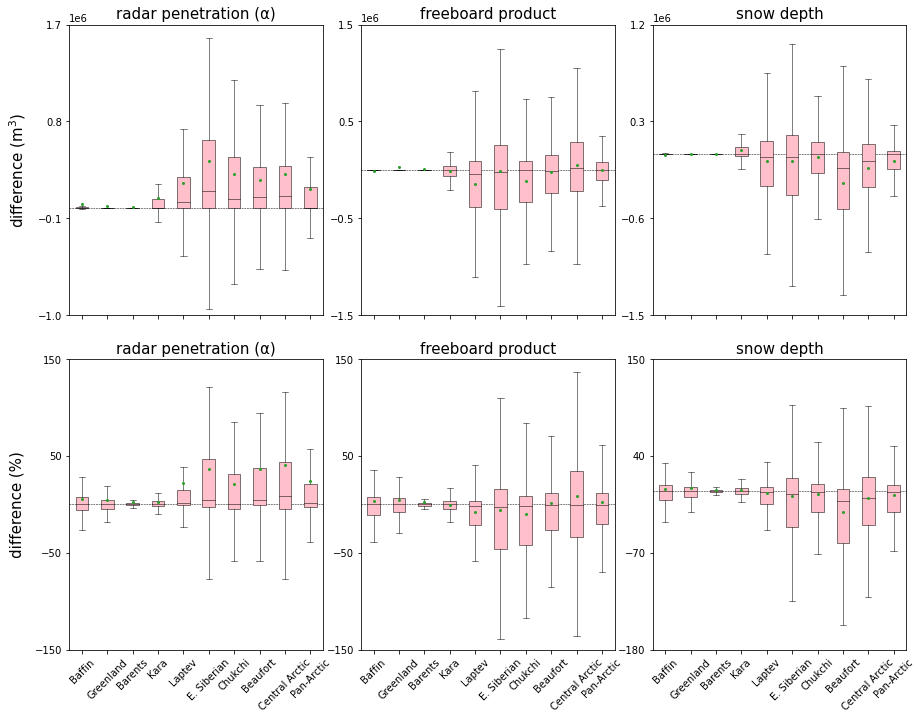

In [12]:
variables = ['radar penetration (\u03B1)','freeboard product','snow depth','radar penetration (\u03B1)','freeboard product','snow depth']
data = [alphas,freeboards,snows,alphas_per,freeboards_per,snows_per,alphas_per,freeboards_per,snows_per]
ylims = [[-1000000,1700000] , [-1500000,1500000], [-1500000,1200000], [-150,150] , [-150,150], [-180,150]] 
yticks = [[-1000000,-100000,800000,1700000] , [-1500000,-500000,500000,1500000], [-1500000,-600000,300000,1200000],
         [-150,-50,50,150] , [-150,-50,50,150], [-180,-70,40,150]]

fig = plt.figure(figsize=(15,11.5))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.15, wspace=0.15)

for count, variable in enumerate(variables):
    ax = fig.add_subplot(spec[count])
    ax.axhline(0,linestyle='dashed',color='black',linewidth=0.5)
    ax.boxplot(data[count], widths=0.5, patch_artist=True,
                    showfliers=False, showmeans = True,
                    medianprops={"color": "black", "linewidth": 0.5},
                    meanprops={"color": "green", "marker": 'o',"markersize":'2'},
                    boxprops={"facecolor": "pink", "edgecolor": "black",
                              "linewidth": 0.5},
                    whiskerprops={"color": "black", "linewidth": 0.5},
                    capprops={"color": "black", "linewidth": 0.5})
    
    if count <3:
        ax.set_xticklabels([])
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    else:
        ax.set_xticklabels(regions,rotation=45)
    ax.set_title(variable,fontsize=15)
    ax.set_ylim(ylims[count])
    ax.set_yticks(yticks[count])
    
    if count == 0:
        ax.set_ylabel('difference (m$^{3}$)',fontsize=15,labelpad=10)
    if count == 3:
        ax.set_ylabel('difference (%)',fontsize=15,labelpad=10)
        
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/tmc_box.png',dpi=400, 
            bbox_inches="tight")